In [53]:
# Initial imports
import pandas as pd
import pandas_datareader.data as web
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

from path import Path
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
import plotly.express as px
import hvplot.pandas

In [2]:
# Read in incident_declation file
# Read in the data from S3 Bucket
url = "https://kkoehn-us-natural-disasters.s3.amazonaws.com/nd_df.csv"
nd_df = pd.read_csv(url)
nd_df

,disaster_number,state,declaration_type,incident_type,declaration_title,incident_begin_date,incident_end_date,designated_area,incident_month,incident_duration,incident_begin_year,region,programs_declared
0,608,CT,DR,Tornado,Tornado & Severe Storms,1979-10-04,1979-10-04,"Hartford (County)(in PMSA 1170,3280,5440)",10,1,1979,Northeast,1
1,609,CA,DR,Earthquake,Earthquake,1979-10-19,1979-10-19,Imperial (County),10,1,1979,West,2
2,612,WA,DR,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Jefferson (County),12,1,1979,West,1
3,612,WA,DR,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Grays Harbor (County),12,1,1979,West,1
4,612,WA,DR,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Snohomish (County),12,1,1979,West,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30252,4564,FL,DR,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Franklin (County),9,14,2020,Southeast,2
30253,4564,FL,DR,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Jefferson (County),9,14,2020,Southeast,2
30254,4564,FL,DR,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Gadsden (County),9,14,2020,Southeast,2
30255,4564,FL,DR,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Liberty (County),9,14,2020,Southeast,2


In [3]:
nd_df=nd_df.drop(['declaration_type'],axis=1)

In [4]:
nd_df.index.name = 'Index'

# Check for outliers

In [5]:
# Create scatterplot for programs declared.
nd_df.hvplot.scatter(x="Index", y="programs_declared")

:Scatter   [Index]   (programs_declared)

In [6]:
# Create scatterplot for incident duration.
nd_df.hvplot.scatter(x="Index", y="incident_duration")

:Scatter   [Index]   (incident_duration)

In [7]:
# Create scatterplot for incident duration vs programs declared.
nd_df.hvplot.scatter(x="incident_duration", y="programs_declared")

:Scatter   [incident_duration]   (programs_declared)

In [8]:
# Remove outlier
nd_df = nd_df.drop(2214)

In [9]:
# Create scatterplot for incident duration.
nd_df.hvplot.scatter(x="Index", y="incident_duration")

:Scatter   [Index]   (incident_duration)

In [10]:
# Create scatterplot for incident duration vs programs declared.
nd_df.hvplot.scatter(x="incident_duration", y="programs_declared")

:Scatter   [incident_duration]   (programs_declared)

In [11]:
nd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30256 entries, 0 to 30256
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   disaster_number      30256 non-null  int64 
 1   state                30256 non-null  object
 2   incident_type        30256 non-null  object
 3   declaration_title    30256 non-null  object
 4   incident_begin_date  30256 non-null  object
 5   incident_end_date    30256 non-null  object
 6   designated_area      30256 non-null  object
 7   incident_month       30256 non-null  int64 
 8   incident_duration    30256 non-null  int64 
 9   incident_begin_year  30256 non-null  int64 
 10  region               30256 non-null  object
 11  programs_declared    30256 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 3.0+ MB


In [12]:
# Create column for average of programs declared for each disaster number.
dnpd_mean = (pd.DataFrame(nd_df.groupby('disaster_number')['programs_declared'].mean())).rename(columns={"programs_declared": "dnpd_mean"}) 
nd_df1 = nd_df.merge(dnpd_mean, how='left', on='disaster_number')
nd_df1

,disaster_number,state,incident_type,declaration_title,incident_begin_date,incident_end_date,designated_area,incident_month,incident_duration,incident_begin_year,region,programs_declared,dnpd_mean
0,608,CT,Tornado,Tornado & Severe Storms,1979-10-04,1979-10-04,"Hartford (County)(in PMSA 1170,3280,5440)",10,1,1979,Northeast,1,1.000000
1,609,CA,Earthquake,Earthquake,1979-10-19,1979-10-19,Imperial (County),10,1,1979,West,2,2.000000
2,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Jefferson (County),12,1,1979,West,1,1.000000
3,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Grays Harbor (County),12,1,1979,West,1,1.000000
4,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Snohomish (County),12,1,1979,West,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30251,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Franklin (County),9,14,2020,Southeast,2,2.357143
30252,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Jefferson (County),9,14,2020,Southeast,2,2.357143
30253,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Gadsden (County),9,14,2020,Southeast,2,2.357143
30254,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Liberty (County),9,14,2020,Southeast,2,2.357143


In [13]:
# Create column for average of programs declared for each state.
statepd_mean = (pd.DataFrame(nd_df.groupby('state')['programs_declared'].mean())).rename(columns={"programs_declared": "statepd_mean"}) 
nd_df2 = nd_df1.merge(statepd_mean, how='left', on='state')
nd_df2

,disaster_number,state,incident_type,declaration_title,incident_begin_date,incident_end_date,designated_area,incident_month,incident_duration,incident_begin_year,region,programs_declared,dnpd_mean,statepd_mean
0,608,CT,Tornado,Tornado & Severe Storms,1979-10-04,1979-10-04,"Hartford (County)(in PMSA 1170,3280,5440)",10,1,1979,Northeast,1,1.000000,1.972727
1,609,CA,Earthquake,Earthquake,1979-10-19,1979-10-19,Imperial (County),10,1,1979,West,2,2.000000,2.107242
2,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Jefferson (County),12,1,1979,West,1,1.000000,2.044211
3,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Grays Harbor (County),12,1,1979,West,1,1.000000,2.044211
4,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Snohomish (County),12,1,1979,West,1,1.000000,2.044211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30251,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Franklin (County),9,14,2020,Southeast,2,2.357143,2.327342
30252,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Jefferson (County),9,14,2020,Southeast,2,2.357143,2.327342
30253,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Gadsden (County),9,14,2020,Southeast,2,2.357143,2.327342
30254,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Liberty (County),9,14,2020,Southeast,2,2.357143,2.327342


In [14]:
# Create column for average of programs declared for each incident type.
incidentpd_mean = (pd.DataFrame(nd_df.groupby('incident_type')['programs_declared'].mean())).rename(columns={"programs_declared": "incidentpd_mean"}) 
nd_df3 = nd_df2.merge(incidentpd_mean, how='left', on='incident_type')
nd_df3

,disaster_number,state,incident_type,declaration_title,incident_begin_date,incident_end_date,designated_area,incident_month,incident_duration,incident_begin_year,region,programs_declared,dnpd_mean,statepd_mean,incidentpd_mean
0,608,CT,Tornado,Tornado & Severe Storms,1979-10-04,1979-10-04,"Hartford (County)(in PMSA 1170,3280,5440)",10,1,1979,Northeast,1,1.000000,1.972727,1.809645
1,609,CA,Earthquake,Earthquake,1979-10-19,1979-10-19,Imperial (County),10,1,1979,West,2,2.000000,2.107242,2.032967
2,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Jefferson (County),12,1,1979,West,1,1.000000,2.044211,1.900839
3,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Grays Harbor (County),12,1,1979,West,1,1.000000,2.044211,1.900839
4,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Snohomish (County),12,1,1979,West,1,1.000000,2.044211,1.900839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30251,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Franklin (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463
30252,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Jefferson (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463
30253,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Gadsden (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463
30254,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Liberty (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463


In [15]:
# Create column for average of programs declared for each month.
monthpd_mean = (pd.DataFrame(nd_df.groupby('incident_month')['programs_declared'].mean())).rename(columns={"programs_declared": "monthpd_mean"}) 
nd_df4 = nd_df3.merge(monthpd_mean, how='left', on='incident_month')
nd_df4

,disaster_number,state,incident_type,declaration_title,incident_begin_date,incident_end_date,designated_area,incident_month,incident_duration,incident_begin_year,region,programs_declared,dnpd_mean,statepd_mean,incidentpd_mean,monthpd_mean
0,608,CT,Tornado,Tornado & Severe Storms,1979-10-04,1979-10-04,"Hartford (County)(in PMSA 1170,3280,5440)",10,1,1979,Northeast,1,1.000000,1.972727,1.809645,2.077874
1,609,CA,Earthquake,Earthquake,1979-10-19,1979-10-19,Imperial (County),10,1,1979,West,2,2.000000,2.107242,2.032967,2.077874
2,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Jefferson (County),12,1,1979,West,1,1.000000,2.044211,1.900839,1.928685
3,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Grays Harbor (County),12,1,1979,West,1,1.000000,2.044211,1.900839,1.928685
4,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Snohomish (County),12,1,1979,West,1,1.000000,2.044211,1.900839,1.928685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30251,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Franklin (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463,2.428986
30252,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Jefferson (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463,2.428986
30253,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Gadsden (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463,2.428986
30254,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Liberty (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463,2.428986


In [16]:
# Create column for average of programs declared for each incident duration length.
durationpd_mean = (pd.DataFrame(nd_df.groupby('incident_duration')['programs_declared'].mean())).rename(columns={"programs_declared": "durationpd_mean"}) 
nd_df5 = nd_df4.merge(durationpd_mean, how='left', on='incident_duration')
nd_df5

,disaster_number,state,incident_type,declaration_title,incident_begin_date,incident_end_date,designated_area,incident_month,incident_duration,incident_begin_year,region,programs_declared,dnpd_mean,statepd_mean,incidentpd_mean,monthpd_mean,durationpd_mean
0,608,CT,Tornado,Tornado & Severe Storms,1979-10-04,1979-10-04,"Hartford (County)(in PMSA 1170,3280,5440)",10,1,1979,Northeast,1,1.000000,1.972727,1.809645,2.077874,1.867414
1,609,CA,Earthquake,Earthquake,1979-10-19,1979-10-19,Imperial (County),10,1,1979,West,2,2.000000,2.107242,2.032967,2.077874,1.867414
2,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Jefferson (County),12,1,1979,West,1,1.000000,2.044211,1.900839,1.928685,1.867414
3,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Grays Harbor (County),12,1,1979,West,1,1.000000,2.044211,1.900839,1.928685,1.867414
4,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Snohomish (County),12,1,1979,West,1,1.000000,2.044211,1.900839,1.928685,1.867414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30251,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Franklin (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463,2.428986,2.173160
30252,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Jefferson (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463,2.428986,2.173160
30253,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Gadsden (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463,2.428986,2.173160
30254,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Liberty (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463,2.428986,2.173160


In [17]:
# Create column for average of programs declared for each year an incident(disaster) begins.
begin_year_mean = (pd.DataFrame(nd_df.groupby('incident_begin_year')['programs_declared'].mean())).rename(columns={"programs_declared": "begin_year_mean"}) 
nd_df6 = nd_df5.merge(begin_year_mean, how='left', on='incident_begin_year')
nd_df6

,disaster_number,state,incident_type,declaration_title,incident_begin_date,incident_end_date,designated_area,incident_month,incident_duration,incident_begin_year,region,programs_declared,dnpd_mean,statepd_mean,incidentpd_mean,monthpd_mean,durationpd_mean,begin_year_mean
0,608,CT,Tornado,Tornado & Severe Storms,1979-10-04,1979-10-04,"Hartford (County)(in PMSA 1170,3280,5440)",10,1,1979,Northeast,1,1.000000,1.972727,1.809645,2.077874,1.867414,1.090909
1,609,CA,Earthquake,Earthquake,1979-10-19,1979-10-19,Imperial (County),10,1,1979,West,2,2.000000,2.107242,2.032967,2.077874,1.867414,1.090909
2,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Jefferson (County),12,1,1979,West,1,1.000000,2.044211,1.900839,1.928685,1.867414,1.090909
3,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Grays Harbor (County),12,1,1979,West,1,1.000000,2.044211,1.900839,1.928685,1.867414,1.090909
4,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Snohomish (County),12,1,1979,West,1,1.000000,2.044211,1.900839,1.928685,1.867414,1.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30251,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Franklin (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463,2.428986,2.173160,2.193622
30252,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Jefferson (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463,2.428986,2.173160,2.193622
30253,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Gadsden (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463,2.428986,2.173160,2.193622
30254,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Liberty (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463,2.428986,2.173160,2.193622


In [18]:
regionpd_mean = (pd.DataFrame(nd_df.groupby('region')['programs_declared'].mean())).rename(columns={"programs_declared": "regionpd_mean"}) 
nd_df7 = nd_df6.merge(regionpd_mean, how='left', on='region')
nd_df7

,disaster_number,state,incident_type,declaration_title,incident_begin_date,incident_end_date,designated_area,incident_month,incident_duration,incident_begin_year,region,programs_declared,dnpd_mean,statepd_mean,incidentpd_mean,monthpd_mean,durationpd_mean,begin_year_mean,regionpd_mean
0,608,CT,Tornado,Tornado & Severe Storms,1979-10-04,1979-10-04,"Hartford (County)(in PMSA 1170,3280,5440)",10,1,1979,Northeast,1,1.000000,1.972727,1.809645,2.077874,1.867414,1.090909,2.032152
1,609,CA,Earthquake,Earthquake,1979-10-19,1979-10-19,Imperial (County),10,1,1979,West,2,2.000000,2.107242,2.032967,2.077874,1.867414,1.090909,1.977634
2,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Jefferson (County),12,1,1979,West,1,1.000000,2.044211,1.900839,1.928685,1.867414,1.090909,1.977634
3,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Grays Harbor (County),12,1,1979,West,1,1.000000,2.044211,1.900839,1.928685,1.867414,1.090909,1.977634
4,612,WA,Flood,"Storms, High Tides, Mudslides & Flooding",1979-12-31,1979-12-31,Snohomish (County),12,1,1979,West,1,1.000000,2.044211,1.900839,1.928685,1.867414,1.090909,1.977634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30251,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Franklin (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463,2.428986,2.173160,2.193622,2.168671
30252,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Jefferson (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463,2.428986,2.173160,2.193622,2.168671
30253,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Gadsden (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463,2.428986,2.173160,2.193622,2.168671
30254,4564,FL,Hurricane,Hurricane Sally,2020-09-14,2020-09-28,Liberty (County),9,14,2020,Southeast,2,2.357143,2.327342,2.531463,2.428986,2.173160,2.193622,2.168671


In [19]:
nd_df7.nunique()

disaster_number        1772
state                    50
incident_type            14
declaration_title       500
incident_begin_date    1319
incident_end_date      1467
designated_area        1992
incident_month           12
incident_duration       127
incident_begin_year      42
region                    5
programs_declared         5
dnpd_mean               362
statepd_mean             50
incidentpd_mean          13
monthpd_mean             12
durationpd_mean         102
begin_year_mean          42
regionpd_mean             5
dtype: int64

In [20]:
reduced_nd_df=nd_df7.drop(['declaration_title','incident_end_date','designated_area','programs_declared'],axis=1)
reduced_nd_df.head(5)

,disaster_number,state,incident_type,incident_begin_date,incident_month,incident_duration,incident_begin_year,region,dnpd_mean,statepd_mean,incidentpd_mean,monthpd_mean,durationpd_mean,begin_year_mean,regionpd_mean
0,608,CT,Tornado,1979-10-04,10,1,1979,Northeast,1.0,1.972727,1.809645,2.077874,1.867414,1.090909,2.032152
1,609,CA,Earthquake,1979-10-19,10,1,1979,West,2.0,2.107242,2.032967,2.077874,1.867414,1.090909,1.977634
2,612,WA,Flood,1979-12-31,12,1,1979,West,1.0,2.044211,1.900839,1.928685,1.867414,1.090909,1.977634
3,612,WA,Flood,1979-12-31,12,1,1979,West,1.0,2.044211,1.900839,1.928685,1.867414,1.090909,1.977634
4,612,WA,Flood,1979-12-31,12,1,1979,West,1.0,2.044211,1.900839,1.928685,1.867414,1.090909,1.977634


In [21]:
unique_nd_df = reduced_nd_df.drop_duplicates(subset = ["disaster_number"])

In [22]:
unique_nd_df.head()

,disaster_number,state,incident_type,incident_begin_date,incident_month,incident_duration,incident_begin_year,region,dnpd_mean,statepd_mean,incidentpd_mean,monthpd_mean,durationpd_mean,begin_year_mean,regionpd_mean
0,608,CT,Tornado,1979-10-04,10,1,1979,Northeast,1.0,1.972727,1.809645,2.077874,1.867414,1.090909,2.032152
1,609,CA,Earthquake,1979-10-19,10,1,1979,West,2.0,2.107242,2.032967,2.077874,1.867414,1.090909,1.977634
2,612,WA,Flood,1979-12-31,12,1,1979,West,1.0,2.044211,1.900839,1.928685,1.867414,1.090909,1.977634
11,613,HI,Flood,1980-02-06,2,1,1980,West,1.0,2.166667,1.900839,1.895943,1.867414,1.708861,1.977634
12,614,AZ,Flood,1980-02-19,2,1,1980,Southwest,2.0,1.848214,1.900839,1.895943,1.867414,1.708861,2.054951


In [23]:
unique_nd_df = unique_nd_df.reset_index(drop=True)

In [24]:
unique_nd_df.index.name = 'Index'
unique_nd_df

,disaster_number,state,incident_type,incident_begin_date,incident_month,incident_duration,incident_begin_year,region,dnpd_mean,statepd_mean,incidentpd_mean,monthpd_mean,durationpd_mean,begin_year_mean,regionpd_mean
Index,,,,,,,,,,,,,,,
0,608,CT,Tornado,1979-10-04,10,1,1979,Northeast,1.000000,1.972727,1.809645,2.077874,1.867414,1.090909,2.032152
1,609,CA,Earthquake,1979-10-19,10,1,1979,West,2.000000,2.107242,2.032967,2.077874,1.867414,1.090909,1.977634
2,612,WA,Flood,1979-12-31,12,1,1979,West,1.000000,2.044211,1.900839,1.928685,1.867414,1.090909,1.977634
3,613,HI,Flood,1980-02-06,2,1,1980,West,1.000000,2.166667,1.900839,1.895943,1.867414,1.708861,1.977634
4,614,AZ,Flood,1980-02-19,2,1,1980,Southwest,2.000000,1.848214,1.900839,1.895943,1.867414,1.708861,2.054951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1767,4559,LA,Hurricane,2020-08-22,8,5,2020,Southeast,2.328125,2.302395,2.531463,2.220588,2.052733,2.193622,2.168671
1768,4561,IA,Severe Storm(s),2020-08-10,8,1,2020,Midwest,2.000000,2.168178,2.189136,2.220588,1.867414,2.193622,2.105007
1769,4562,OR,Fire,2020-09-07,9,57,2020,West,2.400000,1.918803,2.022704,2.428986,2.618497,2.193622,1.977634


# Create region dataframes

In [25]:
NE_df = unique_nd_df.query("region in 'Northeast'")

In [26]:
NE_df

,disaster_number,state,incident_type,incident_begin_date,incident_month,incident_duration,incident_begin_year,region,dnpd_mean,statepd_mean,incidentpd_mean,monthpd_mean,durationpd_mean,begin_year_mean,regionpd_mean
Index,,,,,,,,,,,,,,,
0,608,CT,Tornado,1979-10-04,10,1,1979,Northeast,1.000000,1.972727,1.809645,2.077874,1.867414,1.090909,2.032152
19,629,PA,Flood,1980-08-19,8,1,1980,Northeast,2.000000,2.056761,1.900839,2.220588,1.867414,1.708861,2.032152
28,641,PA,Flood,1981-06-15,6,1,1981,Northeast,2.000000,2.056761,1.900839,2.134524,1.867414,1.672727,2.032152
36,650,MA,Fire,1981-12-03,12,1,1981,Northeast,2.000000,1.909574,2.022704,1.928685,1.867414,1.672727,2.032152
47,661,CT,Flood,1982-06-14,6,1,1982,Northeast,1.500000,1.972727,1.900839,2.134524,1.867414,1.371212,2.032152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,4410,CT,Severe Storm(s),2018-09-25,9,1,2018,Northeast,2.000000,1.972727,2.189136,2.428986,1.867414,2.160000,2.032152
1712,4445,VT,Flood,2019-04-15,4,1,2019,Northeast,2.000000,1.995690,1.900839,2.125300,1.867414,2.107394,2.032152
1724,4457,NH,Severe Storm(s),2019-07-11,7,1,2019,Northeast,2.000000,2.070513,2.189136,2.028926,1.867414,2.107394,2.032152


In [27]:
NE_df.incident_begin_year = pd.to_datetime(NE_df['incident_begin_year'], format='%Y')

NE_df.head(5)

C:\Users\Dee\anaconda3\envs\mlenv\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,disaster_number,state,incident_type,incident_begin_date,incident_month,incident_duration,incident_begin_year,region,dnpd_mean,statepd_mean,incidentpd_mean,monthpd_mean,durationpd_mean,begin_year_mean,regionpd_mean
Index,,,,,,,,,,,,,,,
0,608,CT,Tornado,1979-10-04,10,1,1979-01-01,Northeast,1.0,1.972727,1.809645,2.077874,1.867414,1.090909,2.032152
19,629,PA,Flood,1980-08-19,8,1,1980-01-01,Northeast,2.0,2.056761,1.900839,2.220588,1.867414,1.708861,2.032152
28,641,PA,Flood,1981-06-15,6,1,1981-01-01,Northeast,2.0,2.056761,1.900839,2.134524,1.867414,1.672727,2.032152
36,650,MA,Fire,1981-12-03,12,1,1981-01-01,Northeast,2.0,1.909574,2.022704,1.928685,1.867414,1.672727,2.032152
47,661,CT,Flood,1982-06-14,6,1,1982-01-01,Northeast,1.5,1.972727,1.900839,2.134524,1.867414,1.371212,2.032152


In [46]:
NE_df_count = (pd.DataFrame(NE_df['incident_begin_year'].value_counts())).rename(columns={"incident_begin_year": "Incidents"}) 
NE_df_count.index.name = 'Year'
NE_df_count = NE_df_count.sort_index()
NE_df_count

,Incidents
Year,
1979-01-01,1
1980-01-01,1
1981-01-01,2
1982-01-01,1
1984-01-01,6
1985-01-01,11
1986-01-01,2
1987-01-01,5
1989-01-01,4


In [33]:
sns.set()

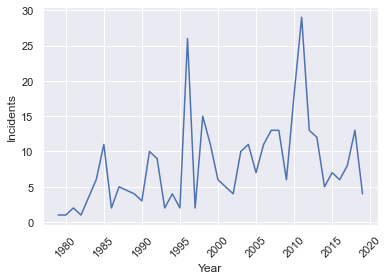

In [34]:
plt.ylabel('Incidents')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.plot(NE_df_count.index, NE_df_count['Incidents'])

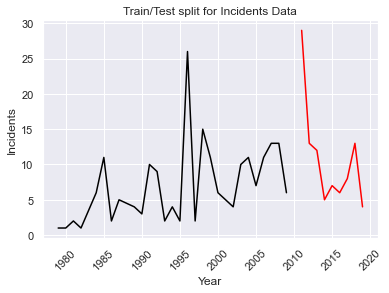

In [42]:
train = NE_df_count[NE_df_count.index < pd.to_datetime("2010-01-01", format='%Y-%m-%d')]
test = NE_df_count[NE_df_count.index > pd.to_datetime("2010-01-01", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Incidents')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.title("Train/Test split for Incidents Data")
plt.show()

In [44]:
y = train['Incidents']

# Autoregressive Moving Average (ARMA) Model

In [45]:
# Define upper and lower bounds around the prediction - 95% confidence
ARMAmodel = SARIMAX(y, order = (1, 0, 1))

C:\Users\Dee\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dee\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [47]:
# Fit the model
ARMAmodel = ARMAmodel.fit()

C:\Users\Dee\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [48]:
# Generate predictions
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

C:\Users\Dee\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\Dee\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


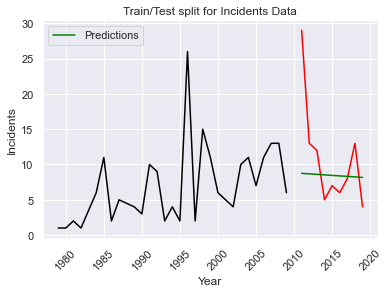

In [50]:
# Plot the results
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Incidents')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.title("Train/Test split for Incidents Data")
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()

In [52]:
arma_rmse = np.sqrt(mean_squared_error(test["Incidents"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  7.459338467213662


# Autoregressive Integrated Moving Average (ARIMA)

In [68]:
ARIMAmodel = ARIMA(y, order = (2, 3, 2))
ARIMAmodel = ARIMAmodel.fit()

C:\Users\Dee\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dee\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dee\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dee\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible st

In [69]:
# Generate predictions
y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

C:\Users\Dee\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\Dee\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


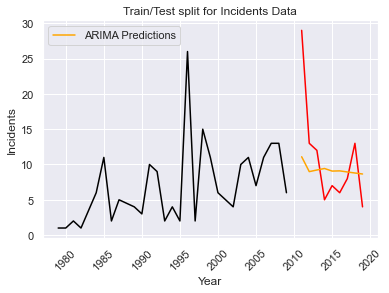

In [70]:
# Plot the results
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Incidents')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.title("Train/Test split for Incidents Data")
plt.plot(y_pred_out, color='Orange', label = 'ARIMA Predictions')
plt.legend()

In [71]:
arma_rmse = np.sqrt(mean_squared_error(test["Incidents"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  6.816204601430094


In [73]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

C:\Users\Dee\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dee\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [72]:
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.legend()

C:\Users\Dee\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dee\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
# View types of data
unique_nd_df.info()

In [ ]:
# Generate our categorical variable list
und_cat = red_und_df.dtypes[red_und_df.dtypes == "object"].index.tolist()
und_cat

In [ ]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(red_und_df[und_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(und_cat)
encode_df.head()

In [ ]:
# Merge one-hot encoded features and drop the originals
red_und_df = red_und_df.merge(encode_df,left_index=True, right_index=True)
red_und_df = red_und_df.drop(und_cat,1)

In [ ]:
red_und_df.index.name = 'Index'
red_und_df.head()

# Use K-Means to create Elbow Curve and clusters
Classifying incident durations of natural disasters.

In [ ]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of K values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(red_und_df)
    inertia.append(km.inertia_)

In [ ]:
# Create the Elbow Curve using hvPlot
elbow_data = {'k': k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

In [ ]:
def get_clusters(k, data):
    # Create a copy of the DataFrame
    data = data.copy()

    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Fit the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

In [ ]:
two_clusters = get_clusters(2,red_und_df)
two_clusters

In [ ]:
# Plotting the 2D-Scatter with x="Annual Income" and y="Spending Score (1-100)"
two_clusters.hvplot.scatter(x="incident_begin_year",y="incident_duration", by="class")

In [ ]:
# Plot the 3D-scatter with x="Annual Income", y="Spending Score (1-100)" and z="Age"
fig = px.scatter_3d(
    two_clusters,
    x="incident_begin_year",
    y="incident_duration",
    z="incident_month",
    color="class",
    symbol="class",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [ ]:
plt.scatter(red_und_df.incident_month, red_und_df.incident_duration)
plt.xlabel('Incident Month')
plt.ylabel('Incident Duration')
plt.show()

# Linear Regression
Create linear regression of months vs incident duration to see any possible trends.

In [ ]:
# The data in the df column must be reshaped into an array with shape (num_samples, num_features)
X = red_und_df.index.values.reshape(-1, 1)
y = red_und_df.programs_declared

In [ ]:
X.shape

In [ ]:
plt.scatter(red_und_df.index, red_und_df.programs_declared)
plt.xlabel('Incident Begin Year')
plt.ylabel('Incident Duration')
plt.show()

In [ ]:
# Create a model with scikit-learn
model = LinearRegression()

In [ ]:
# Fit the data into the model
model.fit(X, y)

In [ ]:
# The model creates predicted y values based on X values
y_pred = model.predict(X)
print(y_pred.shape)

In [ ]:
# Plot the results. The best fit line is red.
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

# Train and test data for KNN(Nearest Neighbors) model
Classify incident duration because it uses proximity to make classifications or predictions about the grouping of an individual data point. 

In [ ]:
# Split our preprocessed data into our features and target arrays
y = unique_nd_df["incident_duration"]
X = unique_nd_df.drop(columns=["incident_duration","state","incident_type",'declaration_title','incident_begin_date','incident_end_date','designated_area','region'])

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)

In [ ]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=400,
                                random_state=78)

In [ ]:
classifier.fit(X_train, y_train)

In [ ]:
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(20)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

In [ ]:
print(classification_report(y_test,y_pred))

# KNN(nearest neighbors) model

In [ ]:
# Start with k=1
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train,y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
           

pred = knn.predict(X_test)

#Predicting and evavluations 

print(confusion_matrix(y_test,pred))

In [ ]:
# Use the elbow method to pick a good K Value:

error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))

plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)

plt.title('Error Rate vs. K Value')

plt.xlabel('K')

plt.ylabel('Error Rate')

In [ ]:
# Retrain the model with that and check the classification report!
# Compare K=1 with K=23
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=1')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=23)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=23')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

In [ ]:
# Predict amount of natural disasters in the future - regression

In [ ]:
# Cluster states with similar disasters

In [ ]:
# Cluster states with similar amounts of disasters

In [ ]:
# Cluster counties with similar disasters

In [ ]:
# Cluster counties with similar amounts of disasters

In [ ]:
# Logistic regression safe or not